In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

# Update matplotlib settings
rcvals = {'xtick.minor.visible': True, 'ytick.minor.visible': True,
          'xtick.direction': 'in', 'ytick.direction': 'in',
          'xtick.top': True, 'ytick.right': True, 'font.family': ['serif'],
          'xtick.major.size': 6, 'ytick.major.size': 6,
          'xtick.minor.size': 3, 'ytick.minor.size': 3,
          'image.interpolation': 'nearest', 'image.origin': 'lower',
          'figure.figsize': [8,6], 'mathtext.fontset':'cm'}
matplotlib.rcParams.update(rcvals)

# Super Bias Generation

Example notebook to create an averaged bias image. For a series of dark ramps:

  1. perform reference pixel correction
  1. fit a polynomial (usually linear function) to each pixel within the ramp to find bias (t=0) frame
  1. averages together resulting bias images
  
The result is a final superbias image file in units of DN.

In [2]:
# Reference pixel correction modules and functions
import ref_pixels
from ref_pixels import robust
from ref_pixels import reffix_hxrg, get_fits_data
from ref_pixels import jl_poly_fit, jl_poly

# Astropy FITS
from astropy.io import fits

# Progress bar
from tqdm.auto import trange, tqdm

In [3]:
def _wrap_bias_fit_data(arg):
    """ Wrapper for multiprocessing """
    args, kwargs = arg

    fname, det = args
    data = get_fits_data(fname, reffix=True, **kwargs)

    nz = det.multiaccum.ngroup
    # Time array
    tarr = np.arange(1, nz+1) * det.time_group

    # Perform the polynomial fitting.
    # Default is to use a fit with deg=1
    # Good practice skip the first frame in case of reset overshoot effects
    deg = kwargs['deg']
    coeff = jl_poly_fit(tarr[1:], data[1:], deg=deg)
    del data

    return coeff[0]

def gen_super_bias(allfiles, det, deg=1, return_std=False, nproc=4, 
                   mn_func=np.median, std_func=robust.medabsdev, **kwargs):
    """ Generate a Super Bias Image

    Read in a number of dark ramps, perform a polynomial fit to the data,
    and return the average of all bias offsets. This a very simple
    procedure that is useful for estimating an initial bias image. 
    Will not work well for weird pixels. 
    """
    
    import multiprocessing as mp
    
    # Set keywords for multiprocessing
    kw = kwargs.copy()
    kw['deg'] = deg
    worker_args = [([f, det],kw) for f in allfiles]
    
    nfiles = len(allfiles)
    
    log_prev = ref_pixels.conf.logging_level
    ref_pixels.setup_logging('WARN', verbose=False)
    
    if nproc>1:
        bias_all = []
        try:
            with mp.Pool(nproc) as pool:
                for res in tqdm(pool.imap_unordered(_wrap_bias_fit_data, worker_args), total=nfiles):
                    bias_all.append(res)
                pool.close()

            # bias_all = pool.map(_wrap_super_bias_for_mp, worker_args)
            if bias_all[0] is None:
                raise RuntimeError('Returned None values. Issue with multiprocess??')
        except Exception as e:
            print('Caught an exception during multiprocess.')
            print('Closing multiprocess pool.')
            pool.terminate()
            pool.close()
            raise e
        else:
            print('Closing multiprocess pool.')
            # pool.close()

        bias_all = np.array(bias_all)
    else:
        bias_all = np.array([_wrap_bias_fit_data(wa) for wa in tqdm(worker_args)])
        
    ref_pixels.setup_logging('INFO', verbose=False)

    print('Calculating average and standard deviation...')
    super_bias     = mn_func(bias_all, axis=0)
    super_bias_std = std_func(bias_all,axis=0)

    res_dict = {
        'super_bias'     : super_bias,
        'super_bias_std' : super_bias_std,
    }

    return res_dict

## Dark FITS Cubes

List of dark ramps saved as FITS files.

In [4]:
import os

indir = '/Users/jarron/SHARK-NIR/20200220_Dark/Dark_250kHz/'
allfits = np.array([indir + f for f in os.listdir(indir) if f.endswith('.fits')])
allfits.sort()

## Define a detector timing object

Define a detector timing object that houses all the necessary information concerning the pixel and frame clocking, detector size and output channels, etc.

In [5]:
# Get shape information for input file
hdul = fits.open(allfits[0])
nz, ny, nx = hdul[0].data.shape
hdul.close()

# Detector timing info
if nx<2048 and ny<2048:
    wind_mode = 'WINDOW'
elif ny<2048:
    wind_mode = 'STRIPE'
else:
    wind_mode = 'FULL'
det = ref_pixels.detops.det_timing(mode='SHARK_250', wind_mode=wind_mode, xpix=nx, ypix=ny, ngroup=nz)

[    refpix:INFO] RAPID readout mode selected.
[    refpix:INFO] Setting nf=1, nd1=0, nd2=0, nd3=0.


In [6]:
# Double check basic frame size and setup information
print(det.to_dict())

{'wind_mode': 'FULL', 'nout': 4, 'xpix': 2048, 'ypix': 2048, 'x0': 0, 'y0': 0}


In [7]:
# Check timing information makes sense
det.times_to_dict()

{'t_frame': 4.278316,
 't_group': 4.278316,
 't_int': 106.9579,
 't_exp': 106.9579,
 't_acq': 111.238304,
 't_int_tot1': 111.236216,
 't_int_tot2': 0.0}

## Create superbias file

Call the function that will perform the reference pixel correction and frame fitting in order to cacluate the final calibration image.

In [8]:
# Keyword arguments to pass to reference pixel correction before slope fitting
kw_refpix = {
    'nchans': det.nout, 'altcol': True, 'in_place': True,
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True, 'perint': False    
}

# Peform linear fits and return average and standard deviation of bias image
# Skip the last file to use as an independent check
# Splits into multiple processes
res = gen_super_bias(allfits[:-1], det, deg=1, nproc=4, return_std=True, **kw_refpix)

  0%|          | 0/19 [00:00<?, ?it/s]

Closing multiprocess pool.
Calculating average and standard deviation...


In [9]:
# Returns a dictionary
print(res.keys())

dict_keys(['super_bias', 'super_bias_std'])


Demonstrate an example subtracting the superbias frame and performing reference pixel correction

In [10]:
# Read in final FITS cube, subtract superbias, and performed ref pixel correction
data_cube = get_fits_data(allfits[-1], bias=res['super_bias'], reffix=True, **kw_refpix)

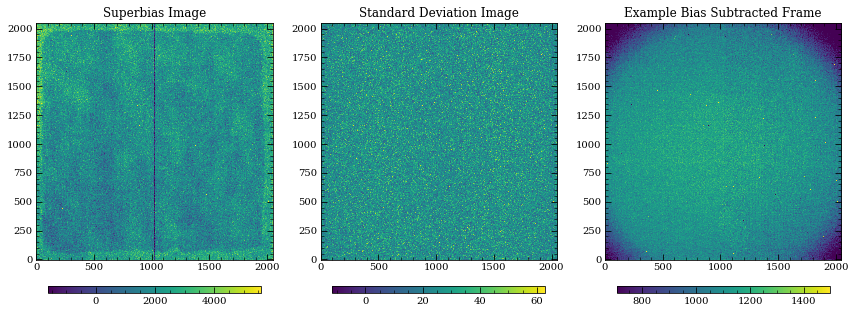

In [11]:
fig, axes = plt.subplots(1,3, figsize=(12,5))

titles = ['Superbias Image', 'Standard Deviation Image', 'Example Bias Subtracted Frame']
for i, im in enumerate([res['super_bias'],  res['super_bias_std'], data_cube[-1]]):
    ax = axes[i]
    
    mn = np.median(im)
    std = robust.std(im)
    vmin, vmax = mn + 5*std*np.array([-1,1])
    
    ax_out = ax.imshow(im, vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])
    
    cbar = fig.colorbar(ax_out, ax=ax, orientation='horizontal',
                        pad=0.08, fraction=0.05, aspect=30, shrink=0.9)
    
fig.tight_layout()

In [12]:
# Save superbias to file
outdir = '/Users/jarron/SHARK-NIR/20200220_Dark/'
file_out = 'SHARK-NIR_250Hz_superbias_example.fits'

hdu = fits.PrimaryHDU( res['super_bias'])
hdu.writeto(outdir + file_out, overwrite=True)